In [11]:
import numpy as np

# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
import time

In [6]:
common_settings = {
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'mass function' : 'T08M200c',
}


p18_cosmo = {

     # P18 1st column table 1 of https://arxiv.org/pdf/1807.06209.pdf
    'omega_b': 0.022383,
    'omega_cdm': 0.12011,
    'h': 0.6732,
    'tau_reio': 0.0543,
    'ln10^{10}A_s': 3.0448,
    'n_s': 0.96605,
    'k_pivot': 0.05,
    'N_ncdm': 1,
    'N_ur': 2.0328,
    'm_ncdm': 0.06
}


gil_marin = {
    'h':0.7,
    'omega_b': 0.023,
    'omega_cdm': 0.1093,
    'n_s':0.95,
    'sigma8': 0.7913,
    'tau_reio': 0.0543,
}

simone = {}

lazanu = {
    'h':0.71,
    'omega_b': 0.0226,
    'omega_cdm': 0.11,
    'n_s':0.963,
    'A_s': 2.43e-9,
    'k_pivot': 0.002,
}

planck_2015 = {
    'omega_b' : 0.02226,
    'omega_cdm' : 0.1186,
    'A_s':  2.139e-9,
    'k_pivot': 0.05,
    'n_s': 0.9677,
    'h' : 0.6781
}

battaglia_16 = {
    'h':0.72,
    'Omega_b':0.043,
    'Omega_cdm':0.25-0.043,
    'n_s':0.96,
    'sigma8':0.8

}

factor_sz = 1e-2

In [29]:
def I_cib_old(z_range, nu, dlnnu=0.05, unit='SI', z_ev_Tdust=0.36,Tdust=24.4,emmissivity=1.75,plaw_SED_highnu=1.7,r_ev_LM=3.6, most_efficient_halo=10.**12.6,halo_size=0.5,common_settings=common_settings):

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
           'output':'cib_monopole',
           'Redshift evolution of dust temperature' :  z_ev_Tdust,
           'Dust temperature today in Kelvins' : Tdust,
           'Emissivity index of sed' : emmissivity,
           'Power law index of SED at high frequency' : plaw_SED_highnu,
           'Redshift evolution of L − M normalisation' : r_ev_LM,
           'Most efficient halo mass in Msun' : most_efficient_halo,
           'Normalisation of L − M relation in [Jy MPc2/Msun/Hz]' : 6.4e-8,
           'Size of of halo masses sourcing CIB emission' : halo_size,

            # M_min_HOD is the threshold above which nc = 1:
            'M_min_HOD' : 10.**10,
            'M1_prime_HOD': 10.**12.51536196*common_settings['h'],


            'M_min' : 1e8*common_settings['h'],
            'M_max' : 1e16*common_settings['h'],
            'z_min' : z_range[0],
            'z_max' : z_range[1],
            'freq_min': nu[0]/10.0**9,
            'freq_max': nu[-1]/10.0**9,
            'mass function': 'T10',
            'dlogfreq': dlnnu,
            'sz_verbose':0

            })

    M.compute()
    nu=np.array(M.cib_monopole()['nu'])
    I0=np.array(M.cib_monopole()['I0'])

    if unit=="SI" or unit=="si":
        return nu*1e9, I0*1e-26
    elif unit=="jansky" or unit=="Jansky" or unit=="Jy":
        return nu, I0


In [30]:
fr=np.linspace(2e2*10**9, 2e4*10**9,1000)
ti = time.perf_counter()
nucib, Icib=I_cib_old([0,10],fr,common_settings=common_settings)
tf = time.perf_counter()
print(f"computed in {tf - ti:0.4f} seconds")

computed in 3.5276 seconds


[]

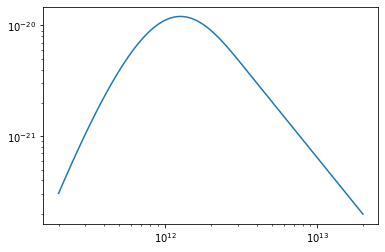

In [10]:
plt.plot(nucib,Icib)
plt.loglog()

In [28]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'mass function': 'T10',
        'concentration parameter' : 'D08',
        'hm_consistency': 1,
       'output':'dcib0dz', 
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun/Hz]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        
        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,
       'M1_prime_HOD': 10.**12.51536196*common_settings['h'],


        'M_min' : 1e6*common_settings['h'],
        'M_max' : 1e16*common_settings['h'],
        'z_min' : 1e-3,
        'z_max' : 9,
        'freq_min': 1e2,
        'freq_max': 4e4,
        'sz_verbose':0
    
        })
ti = time.perf_counter()    
M.compute()
tf = time.perf_counter()
print(f"computed in {tf - ti:0.4f} seconds")

computed in 2.4217 seconds


In [26]:
get_dcib0dz_at_z_and_nu = np.vectorize(M.get_dcib0dz_at_z_and_nu)
# nu_arr  = [215,353,545,857,3000] # in GHz
nu_arr  = np.geomspace(2e2,2e4,1000)
for nu in nu_arr:
    z = np.linspace(0.01,6.,1000)
    dcib0dz = nu*get_dcib0dz_at_z_and_nu(z,nu)
    norm = np.trapz(dcib0dz,z)
#     plt.plot(z,dcib0dz/norm,label=str(nu))
# plt.xlabel('redshift, z')
# plt.ylabel('dcib0/dz')
# plt.grid(which='both')
# plt.legend()